# HW02:  Effect of Enthalpy Specific Heat (cp) on Throttled Otto Cycle
### ME331: Advanced Thermodynamics
#### Prof. George Sidebotham, Fall 2023 
The main goal of this Workshop is to practice fundamental thermodynamic calculations with a perfect gas as the working fluid in a closed system (i.e. in a piston/cylinder).  An "appreciation" for the difference between a calorically perfect gas (specific heat is a constant), and a thermally perfect gas (specific heat is a function of temperature) is another goal. The example problem is to investigate the effect of the specific heat on the Ideal Throttled Otto cycle (Ch 7 of textbook) for several cases, namely:
1.  Cold Air Standard model (cp = constant, evaluated at ambient conditions)
2.  Hot Air model (cp = constant, but evaluated at an average cycle temperature)
3.  Process dependent model (cp = constant for each process, but with values appropriate to each)
4.  Variable specific heat model (cp varies continuously with temperature)

A 4th order polynomical fit to the specific heats of air as a function temperature is shown in this plot (with source data from the JANAF tables, and modified to return air values, on a mass basis).  There is no "underlying physics" in this function, it is just a curve fit to discrete published data.  The underlying reason behind the functional dependence of cp on temperature is actually related to quantum mechanical effects.  Engineers generally just need to just use it, however, not dive into that (as interesting as it may be).

For this exercise, the term "basis temperature" means the temperature for which the cp value is calculated (not any specific temperature in the cycle).  For example, for the "cold air standard model", the basis temperature is 298K, for which the cp value is close to 1.0 kJ/kg/K.  If the chosen basis temperature were 2000K, the cp value used would be close to 1.25 kJ/kg/K.

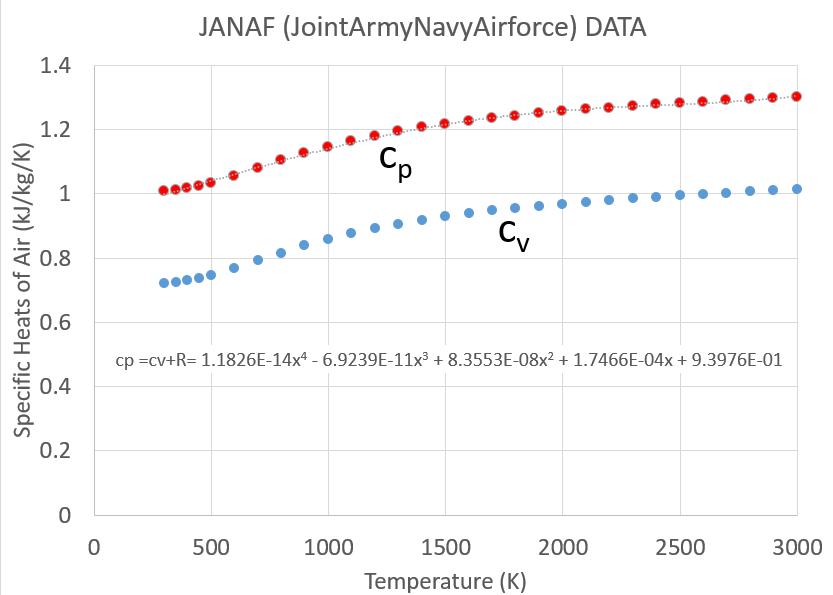



In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# INPUT PARAMETERS
speed = 2000.   #rev/min, engine speed
n_cylinder = 4.   #number of cylinders
Vd = 0.8   #liters, displacement volume
cpr = 12   #compression ratio
T_inf = 298   #K, ambient temperature
P_inf = 1.0   #atm, ambient pressure
P_intake = 0.6  #atm, intake manifold pressure
P_exhaust = 1.2  #atm, exhaust manifold pressure
R = 287.     #J/kg/K, gas constant of air
qcomb = 2.73e6  #J/kg, chemical energy converted to thermal energy during combustion

In [3]:
# DERIVED FIXED PARAMETERS
Vc = Vd/(cpr-1)   #liters, clearance volume
mass_inducted = (P_intake*101325)*(Vd/1000)/R/T_inf
print(f'mass inducted = {mass_inducted*1000:.4g} g, which is different than mass in the cylinder')
# Known thermodynamic properties
#UNIT ALERT:  T is given in K, but P in atm and V in liters must be converted to strict SI units
# unless they appear as ratios (like P2/P1)
# 1 atm = 101325 N/m**2, 1 m**3 = 1000 liters
# cp and R are in J/kg/K, not kJ, so cp units are converted to strict SI in the cp function.

P1 = P_intake; P5 = P_exhaust; P6 = P_exhaust; P7 = P_intake
V1 = Vd + Vc; V2 = Vc; V3 = Vc; V4 = Vd + Vc; V5 = Vd + Vc; V6 = Vc; V7 = Vc

mass inducted = 0.5687 g, which is different than mass in the cylinder


In [4]:
# SPECIFIC HEAT FROM POLYNOMIAL
def cp(T):
    #Function takes temperature (in K) as input and returns enthalpy specific heat (cp) in J/kg/K
    c4 = 1.1826e-14
    c3 = -6.9239e-11
    c2 = 8.3553e-8
    c1 = 1.7466e-4
    c0 = 9.3976e-1
    cp = c4*T**4 + c3*T**3 + c2*T**2 + c1*T**1 + c0   
    return cp*1000

### Here is an "Indicator Diagram" (i.e. PV) for the Ideal Throttled Otto Cycle
The cycle starts (state 1) with the cylinder at Bottom Dead Center (BDC, where volume equals clearance plus displacement), filled with gas at a temperature NEAR ambient, but not quite, and at the intake manifold pressure.  The processes are:

1-2:  Compression Stroke:  isentropic compression to Top Dead Center (TDC, where volume is clearance)

2-3:  Combustion: Instantaneous (hence constant volume) conversion of chemical energy thermal ("equivalent heat addition")

3-4:  Power Stroke:  isentropic expansion to BDC 

4-5:  Blow Down: instantaneous (hence constant volume) venting to exhaust manifold (isentropic expansion of remaining gases).  Temperature remains constant.

5-6:  Exhaust Stroke: constant pressure, as mass exits thru exhaust valve with no pressure drop

6-7:  Valve Overlap:  instantaneous (hence constant volume) venting to intake manifold (isentropic expansion of remaining gases.  Remaining gas (residual gas) is still hot.

7-1:  Intake Stroke:  constant pressure, as mass enters (with no pressure drop) and mixes with residual gases.

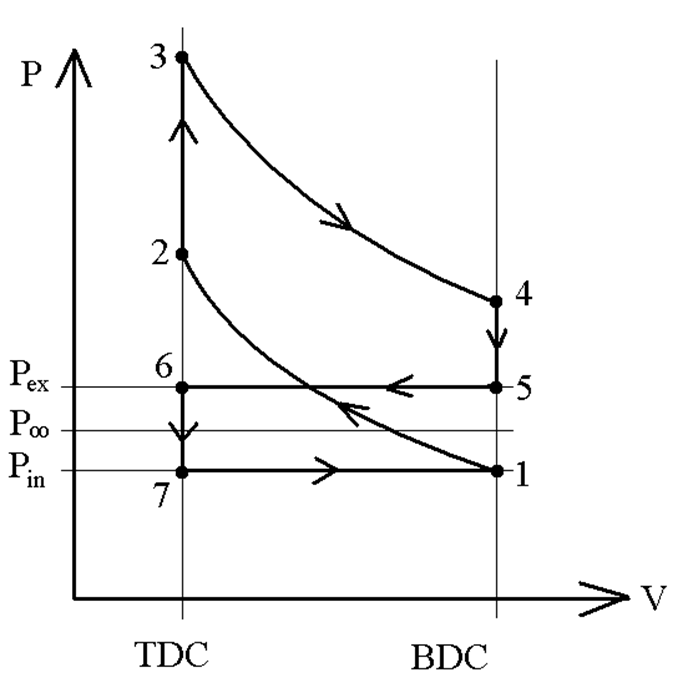

In [5]:
# IDEAL THROTTLED OTTO CYCLE ANALYSIS (with constant cp)

def ideal_otto(T):   
    # Function takes in temperature (in K) as input, and runs several cycles of an ideal throttled Otto cycle
    # which should settle down.  It's like what happens when a cold car engine is started.
    cv = cp(T)-R       #J/kg/K, internal energy specific heat
    k = cp(T)/cv       #ratio of specific heats
    effy_ideal = 1 - (1/cpr)**(k-1)   #This "classic formula" is the efficiency of an unthrottled Otto cycle
    cycles = 0         #will count number of cycles needed to converge
    T1_next = 400      #K, this arbitrary value is needed to get into while loop.
    T1 = T_inf         #NOTE.  T1, the temp at start of compression, is actually unknown, but will be close to T_inf
    #It will be determined as part of the analysis, as several cycles are run until successive cycles are consistent
    #(within a defined tolerance).  The gases at the start of compression is a mixture of fresh gas and residual gas
    #from the previous cycle
    converge = 0.00001   #A convergence criterion to determine how many cycles need to run to settle to steady behavior
    while abs(T1_next - T1) > converge:
        #COMPRESSION STROKE (1-2)
        T1 = T1_next        #Update the temperature at start of compression (from previous cycle)      
        print(f'After {cycles} cycles, T1 = {T1}K')
        mass = (P1*101325)*((Vd + Vc)/1000)/R/T1  #kg, the mass in the cylinder at start of compression, not the inducted mass
        T2 = T1*(V2/V1)**(-R/cv)          #K, from isentropic compression
        P2 = P1*(T2/T1)*(V1/V2)           #N/m**2, from ideal gas law
        Q12 = 0                           #J, adiabatic process
        W12 = Q12 - mass*cv*(T2 - T1)     #J, from energy balance, could used integral PdV, but why?
        #COMBUSTION PROCESS (2-3)       
        T3 = T2 + qcomb/(cp(T) - R)       #K, from combustion
        P3 = P2*T3/T2                     #N/m**2, from ideal gas law
        W23 = 0                           #J, constant volume combustion assumed
        Q23 = mass*qcomb                  #J, "heat" of combustion
        #POWER STROKE (3-4)
        T4 = T3*(V4/V3)**(-R/cv)          #K,from isentropic expansion
        P4 = P3*(T4/T3)*(V3/V4)           #atm, could have used P4=mass*R*T4/(V4/1000)/101325
        Q34 = 0                           #J, adiabatic process
        W34 = Q34 - mass*cv*(T4 - T3)     #J, from energy balance
        #BLOW-DOWN (4-5)
        T5 = T4*(P5/P4)**(R/cp(T))        #K, gases that remain in cylinder undergo an isentropic expansion. 
                                          #Gases that exit to the exhaust manifold are simply vented.  A turbocharger
                                          #placed after the exhaust valve would capture some of that dissipated pressure.
        #EXHAUST STROKE (5-6)
        T6 = T5                              #K, Effect of "compression" exactly cancelled by work to push gases out
        W56 = -(P_exhaust*101325)*(Vd/1000)  #J, Work of exhaust
        #VALVE OVER-LAP (6-7)
        T7 = T6*(P7/P6)**(R/cp(T))         #K, gases that remain in cylinder undergo an isentropic expansion,
                                           #with back flow into the intake manifold.
        mass_clearance = (P_intake*101325)*(Vc/1000)/R/T7    #kg, the mass that remains after exhaust
        #INTAKE STROKE (7-1)
        W71 = (P_intake*101325)*(Vd/1000)  #J, Work of intake
        T1_next = (mass_inducted*T_inf + mass_clearance*T7)/(mass_inducted + mass_clearance)   #K, This formula
                                           #is from an energy balance by simply mixing the hot residual gas with fresh intake
        cycles += cycles                   #count cycles
    #CYCLE CALCULATIONS
    Wpump = (P_inf - P_intake)*101325 * (Vd/1000)
    Wcycle = W12 + W34 + W56 + W71        
    effy = Wcycle/Q23
    mass_flow_rate = n_cylinder*mass_inducted/2 * (speed/60)
    power = n_cylinder * Wcycle / 2 * (speed/60)
    print(f'It took {cycles} cycles to converge (T1 to {converge}K)')
    print(f'\nT2 = {T2:.0f}K, P2 = {P2:.2f} atm, W12 = {W12:.1f} J, Q12 = {Q12} J')
    print(f'T3 = {T3:.0f}K, P3 = {P3:.2f} atm, W23 = {W23:.1f} J, Q23 = {Q23:.1f} J')
    print(f'T4 = {T4:.0f}K, P4 = {P4:.2f} atm, W34 = {W34:.1f} J, Q34 = {Q34:.1f} J')
    print(f'After blowdown (4-5), T5 = {T5:.0f} K')
    print(f'After valve over-lap, T7 = {T7:.0f} K')
    print(f'Exhaust work = {W56}J, Intake work = {W71}J')
    print(f'Net Work = {Wcycle:.1f}J, Pumping work = {Wpump:.1f}J')
    print(f'Cycle efficiency = {effy:.3f}.  Unthrottled efficiency = {effy_ideal:.3f}')
    print(f'Power Output = {power/1000:.1f} kW = {power/1000*1.34102:.1f} hp')
    print(f'Mass flow rate = {mass_flow_rate*3600:.3g} kg/hour')
              
    return effy
    

### Model 1:  Cold air standard
This ideal model assumes a constant specific heat value, with the value being that of the ambient.  This model has simple closed form solutions

In [6]:
#T_basis = float(input('enter a temperature (in K) for which cp will be based:  K'))
T_basis = 298   #K, basis temperature
print(f'For a basis temperature T = {T_basis:.0f}K, cp = {cp(T_basis):.0f} J/kg/K\n')
effy =ideal_otto(T_basis)

For a basis temperature T = 298K, cp = 997 J/kg/K

After 0 cycles, T1 = 400K
After 0 cycles, T1 = 317.74306204308954K
After 0 cycles, T1 = 316.9942647215667K
After 0 cycles, T1 = 316.9864613400535K
After 0 cycles, T1 = 316.986379908454K
It took 0 cycles to converge (T1 to 1e-05K)

T2 = 865K, P2 = 19.65 atm, W12 = -227.0 J, Q12 = 0 J
T3 = 4707K, P3 = 106.92 atm, W23 = 0.0 J, Q23 = 1592.2 J
T4 = 1725K, P4 = 3.27 atm, W34 = 1235.7 J, Q34 = 0.0 J
After blowdown (4-5), T5 = 1293 K
After valve over-lap, T7 = 1060 K
Exhaust work = -97.272J, Intake work = 48.636J
Net Work = 960.0J, Pumping work = 32.4J
Cycle efficiency = 0.603.  Unthrottled efficiency = 0.634
Power Output = 64.0 kW = 85.8 hp
Mass flow rate = 136 kg/hour


### Model 2:  Hot Air Standard
This is the same as model 1, but, uses a basic temperature of 2000K, a rough eyeballed "average" temperature in the cycle
T_basis = 2000K, after consulting the results of the Cold Air Standard model.

In [7]:
#T_basis = float(input('enter a temperature (in K) for which cp will be based:  K'))
T_basis = 2000  #K, basis temperature
print(f'For a basis temperature T = {T_basis:.0f}K, cp = {cp(T_basis):.0f} J/kg/K')
effy =ideal_otto(T_basis)

For a basis temperature T = 2000K, cp = 1259 J/kg/K
After 0 cycles, T1 = 400K
After 0 cycles, T1 = 318.19016992158924K
After 0 cycles, T1 = 317.56150067863354K
After 0 cycles, T1 = 317.556039876128K
After 0 cycles, T1 = 317.55599239276506K
It took 0 cycles to converge (T1 to 1e-05K)

T2 = 662K, P2 = 15.00 atm, W12 = -194.6 J, Q12 = 0 J
T3 = 3471K, P3 = 78.71 atm, W23 = 0.0 J, Q23 = 1589.3 J
T4 = 1666K, P4 = 3.15 atm, W34 = 1021.1 J, Q34 = 0.0 J
After blowdown (4-5), T5 = 1337 K
After valve over-lap, T7 = 1142 K
Exhaust work = -97.272J, Intake work = 48.636J
Net Work = 777.8J, Pumping work = 32.4J
Cycle efficiency = 0.489.  Unthrottled efficiency = 0.520
Power Output = 51.9 kW = 69.5 hp
Mass flow rate = 136 kg/hour


## HW02:  Process-Dependent Specific Heat Model
Now it's YOUR turn.  A good idea (but not strictly "required") is to research an actual spark ignition (SI) engine, and set parameters accordingly (i.e. number of cylinders, displacement volume, etc.) and then compare the predictions of this idealized problem to an actual engine.  You should expect significant deviations as the theory here neglects many real effects at all levels, but is intended to capture the most important characteristics of actual SI engines.
### First, write code that will generate 2 plots:  Power Output vs Basis Temp, and Cycle Efficiency vs Basis Temp
This exercise will give you a "feel" for the sensitivity of the performance based on the assumption of a fixed cp value.  Range of basis temperature should be between 298K and 3000K (the range for which polynomial is based).  If you're curious (I am), what happens to the polynomial OUTSIDE of this range???
###  Then, modify code so that each process uses a different cp value, an appropriate average for that process
This exercise will indicate that use of appropriate cp values for individual steps can improve the accuracy of calculations with minimal increase in complexity of the calculations.
#### EXTRA CREDIT:  For the super motivated, modify code to allow for cp to be a continuously variable function, which will require a fundamental change in the way the cycle is analyzed.  This might show you why/how assuming a constant specific heat for a process simplifies analysis in a dramatic way.  And if the constant value is "suitably chosen", then the error involved is much less than other real effects (like heat loss to the cylinder walls, or instantaneous combustion, or pressure drop across valves drops for example).

Build on this Jupyter Notebook and/or migrate the problem to any software you'd like.  Submit a technical report, either as a detailed .ppt or a document (submitted in pdf form).  Work in teams, but include a section that describes each team members primary role and contribution.  All teammates should come away with a firm grasp. Use exercises like this to build your personal toolbox.  If you are not an experienced programmer, you'll learn more if you work on the programming, rather than let somebody in your team that already has that skill just do it for you.  I'm just sayin...